# Практическая работа
Баранов Д.А. ИВТ 2.1

# Предсказание уровня дохода по данным переписи населения США
### Датасет Adult Census Income

# 2. Оглавление

## Содержание
1. [Описание задачи](#Описание-задачи)
2. [Загрузка данных](#Загрузка-данных)
3. [Предварительный анализ (EDA)](#Предварительный-анализ)
4. [Предобработка данных](#Предобработка-данных)
5. [Разделение на выборки](#Разделение-на-выборки)
6. [Обучение моделей](#Обучение-моделей)
7. [Сравнение моделей](#Сравнение-моделей)
8. [Сохранение лучшей модели](#Сохранение-модели)

# 1. Описание задачи
Целью проекта является построение модели, способной предсказать, имеет ли человек доход более 50 000 долларов в год, основываясь на социально-демографических данных из переписи населения США 1994.

# 2. Загрузка данных

1. Разархивировать и изучить данные

In [5]:
import pandas as pd
import zipfile

with zipfile.ZipFile('/content/adult.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/adult_dataset')

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Загрузка train-данных и проверка
df = pd.read_csv('/content/adult_dataset/adult.data', header = None, names = columns, na_values = ' ?', skipinitialspace= True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 3. Предварительный анализ (EDA)

In [6]:
df.shape
df.dtypes
df.isnull().sum()
df['income'].value_counts(normalize = True)

,proportion
income,
<=50K,0.75919
>50K,0.24081


Text(0.5, 1.0, 'Распределение доходов')

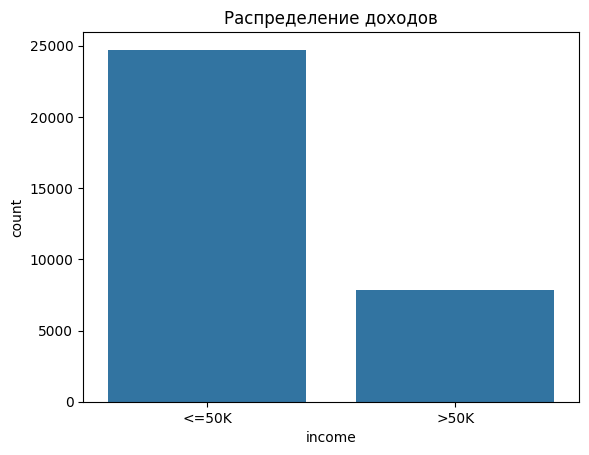

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x = 'income', data = df)
plt.title("Распределение доходов")

,0
age,"Axes(0.125,0.11;0.168478x0.77)"
capital-gain,"Axes(0.327174,0.11;0.168478x0.77)"
capital-loss,"Axes(0.529348,0.11;0.168478x0.77)"
hours-per-week,"Axes(0.731522,0.11;0.168478x0.77)"


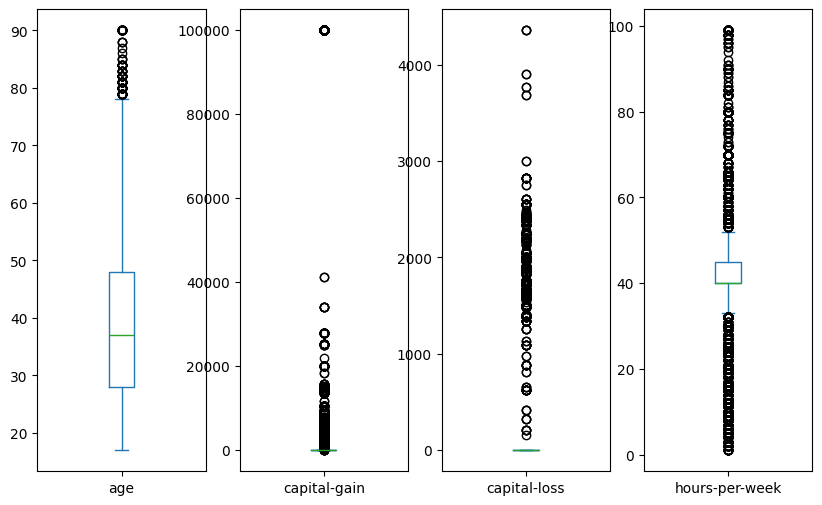

In [14]:
# Boxpot по количественным признакам
df[['age', 'capital-gain', 'capital-loss', 'hours-per-week']].plot(kind='box', subplots=True, figsize=(10, 6))

# 4. Предобработка данных

In [15]:
# Удалим пропуски
df.dropna(inplace=True)

# Закодируем целевую переменную
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['income'] = le.fit_transform(df['income']) # <=50K = 0, >50K = 1

Разделим признаки:

In [16]:
cat_cols = [col for col in df.select_dtypes(include='object').columns if col != 'income']
num_cols = [col for col in df.select_dtypes(exclude='object').columns if col != 'income']

In [17]:
print("cat_cols:", cat_cols)
print("num_cols:", num_cols)

cat_cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
num_cols: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


# 5. Разделение на выборки

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('income', axis=1)
y = df['income']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 42)

In [19]:
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


# 6. Построение пайплайна обработки + моделей

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Преобразование данных
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

Пример: Логистическая регрессия

In [23]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

# 7. Оценка качества модели

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3708
           1       0.74      0.62      0.68      1176

    accuracy                           0.86      4884
   macro avg       0.81      0.78      0.79      4884
weighted avg       0.85      0.86      0.85      4884



# 8. Сравнение моделей

In [27]:
models = {
    'LogisticRegression': LogisticRegression(max_iter = 1000),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

for name, model in models.items():
  pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('classifier', model)
  ])
  pipe.fit(X_train, y_train)
  preds = pipe.predict(X_val)
  acc = accuracy_score(y_val, preds)
  print(f"{name}: Accuracy = {acc:.4f}")

LogisticRegression: Accuracy = 0.8563
DecisionTree: Accuracy = 0.8143
RandomForest: Accuracy = 0.8559


# 9. Сохранение модели

In [29]:
import joblib

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

final_model.fit(X_train, y_train)
joblib.dump(final_model, 'model.pkl')

['model.pkl']

# 10. Заключение

## Заключение
Проведен полный цикл анализа данных: от загрузки и предобработки до обучения и сохранения финальной модели. Модель может быть использована в виде сервиса для предсказания уровня дохода на основе новых данных.

# Продвинутые модели: XGBoost, CatBoost, SVM, MLP

In [31]:
!pip install xgboost catboost scikit-learn

In [33]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

advanced_models = {
    "XGBoost": XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'),
    "CatBoost": CatBoostClassifier(verbose = 0),
    "SVM": SVC(probability = True),
    "MLP": MLPClassifier(max_iter = 300)
}

for name, model in advanced_models.items():
  pipe = Pipeline([
      ('preprocessor', preprocessor),
      ('model', model)
  ])
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_val)
  print(f"{name}: Accuracy = {accuracy_score(y_val, y_pred):.4f}, F1 = {f1_score(y_val, y_pred):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:19:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: Accuracy = 0.8741, F1 = 0.7203
CatBoost: Accuracy = 0.8747, F1 = 0.7148
SVM: Accuracy = 0.8640, F1 = 0.6847
MLP: Accuracy = 0.8407, F1 = 0.6698


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


# Загрузка модели на Kaggle

In [35]:
!pip install -q kaggle

# Загрузка токена **kaggle.json** в Colab

In [43]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.config/kaggle'

!mkdir -p /root/.config/kaggle
!mkdir -p /content/output_dir

!cp kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json

!kaggle --version
!ls -l /root/.config/kaggle/kaggle.json

Kaggle API 1.7.4.5
-rw------- 1 root root 65 Jun  1 11:25 /root/.config/kaggle/kaggle.json


# Загрузка модели

In [44]:
!cp -r /content/model.pkl /content/output_dir
!kaggle datasets init -p /content/output_dir

from google.colab import files
files.view('/content/output_dir/dataset-metadata.json')

Data package template written to: /content/output_dir/dataset-metadata.json


<IPython.core.display.Javascript object>

In [45]:
!kaggle datasets create -p /content/output_dir

Starting upload for file model.pkl
100% 62.1M/62.1M [00:00<00:00, 74.3MB/s]
Upload successful: model.pkl (62MB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/dmitrii74/Model-Adult-Census-Income


# ROC-кривая, PR-кривая, SHAP, LIME

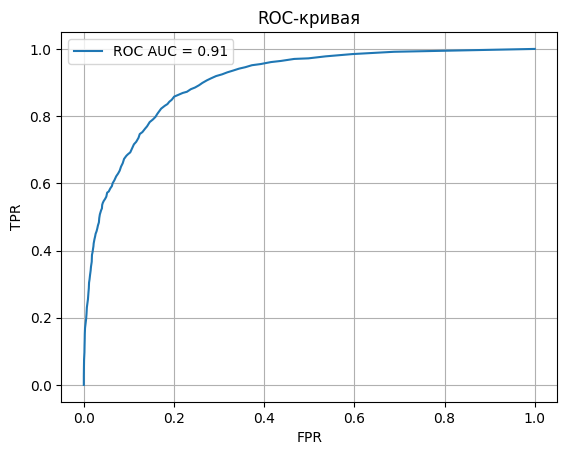

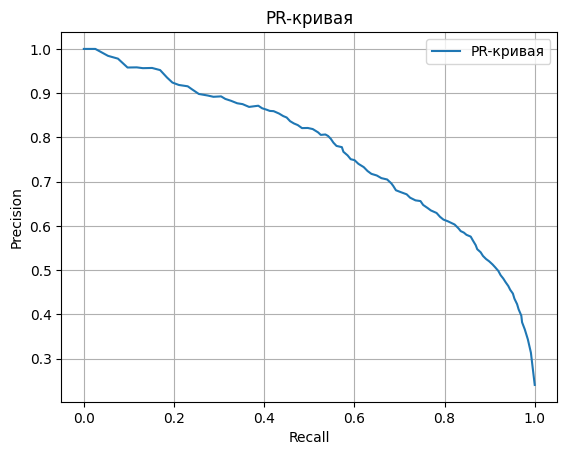

In [47]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f'ROC AUC = {auc(fpr, tpr):.2f}')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC-кривая')
plt.legend(); plt.grid(); plt.show()

plt.plot(recall, precision, label = 'PR-кривая')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid()
plt.legend(); plt.title('PR-кривая'); plt.show()

# SHAP:

In [49]:
print(final_model.named_steps.keys())

dict_keys(['preprocessor', 'classifier'])


In [55]:
!pip install shap

import shap
import numpy as np

ohe = preprocessor.named_transformers_['cat']['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

X_test_transformed = preprocessor.transform(X_test)

if hasattr(X_test_transformed, "toarray"):
  X_test_transformed_df = pd.DataFrame(X_test_transformed.toarray(), columns=all_feature_names)
else:
  X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

model = final_model.named_steps['classifier']

explainer = shap.Explainer(model, X_test_transformed_df)

shap_values = explainer(X_test_transformed_df)

shap.plots.beeswarm(shap_values)

100%|===================| 9761/9770 [18:10<00:01]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.671000, while the model output was 0.770000. If this difference is acceptable you can set check_additivity=False to disable this check.

# Логистическая регрессия

Модель предсказывает вероятность принадлжености к классу `1` по формуле:

$$
P(y=1|x) = \\frac{1}{1 + e^{-z}}, \\text{ где } z = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n x_n
$$

Где:
- $x_i$ - входные признаки
- $w_i$ - веса
- $z$ - линейная комбинация признаков
